L'objectif est de predire $\rho$, $\sigma_a$ et $\sigma_c$, en fonction de $E_r$, $F_r$, et $T_r$, signaux a droite du domaine en toute temps 

## Les imports

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from ast import literal_eval as l_eval

Using TensorFlow backend.


In [ ]:
np.set_printoptions(precision = 3)

# PREPARATION

## Chargement des donnees

In [ ]:
# """ VERSION COLAB """

# to load data from my personal github repo (update it if we have to)
import os
if not os.path.exists("assets"):
    print("Data wansn't here. Let's download it!")
    !git clone https://github.com/desmond-rn/assets.git
else:
    print("Data already here. Let's update it!")
    %cd assets
    # %rm -rf assets
    !git pull https://github.com/desmond-rn/assets.git
    %cd ..

print("\n")
!ls assets/dataframes/inverse

# df_t_path = "assets/dataframes/inverse/df_temporal.csv"
# df_s_path = "assets/dataframes/inverse/df_spatial.csv"

df_t_path = "assets/dataframes/inverse/df_temporal_"
df_s_path = "assets/dataframes/inverse/df_spatial_"

Data wansn't here. Let's download it!
Cloning into 'assets'...
remote: Enumerating objects: 162, done.
remote: Total 162 (delta 0), reused 0 (delta 0), pack-reused 162
Receiving objects: 100% (162/162), 124.13 MiB | 20.12 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Checking out files: 100% (13/13), done.


df_spatial_part1.csv  df_spatial_part4.csv   df_temporal_part3.csv
df_spatial_part2.csv  df_temporal_part1.csv  df_temporal_part4.csv
df_spatial_part3.csv  df_temporal_part2.csv


In [ ]:
# """ VERSION JUPYTER """

# # to load data locally

# %ls "../../data"

# df_t_path = "../../data/df_temporal.csv"
# df_s_path = "../../data/df_spatial.csv"

Les donnees temporelles (qui contiennent $E_r$, $F_r$, et $T_r$)

In [ ]:
# types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
# converters={'t':l_eval, 'E_l':l_eval, 'F_l':l_eval, 'T_l':l_eval, 'E_r':l_eval, 'F_r':l_eval, 'T_r':l_eval}      # on veut convertir les str en listes

# df_t = pd.read_csv(df_t_path, thousands=',', dtype=types, converters=converters)

# df_t.head(2)

In [ ]:
types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
converters={'t':l_eval, 'E_l':l_eval, 'F_l':l_eval, 'T_l':l_eval, 'E_r':l_eval, 'F_r':l_eval, 'T_r':l_eval}      # on veut convertir les str en listes

df_t_part1 = pd.read_csv(df_t_path+"part3.csv", thousands=',', dtype=types, converters=converters)
df_t_part2 = pd.read_csv(df_t_path+"part4.csv", thousands=',', dtype=types, converters=converters)

df_t = pd.concat([df_t_part1, df_t_part2], ignore_index=True)
df_t.head(2)

,x_min,x_max,N,c,a,C_v,CFL,precision,t_0,t_f,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_expr,T_0_expr,dt,step_count,t,E_l,F_l,T_l,E_r,F_r,T_r
0,0,1,500,299,0.01372,0.14361,0.99,0.000001,0,0.005,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000007,756,"[0, 6.62207e-06, 1.32441e-05, 1.98662e-05, 2.6...","[8.575, 8.575, 8.67718, 8.78096, 8.88511, 8.98...","[0, 8.28606e-16, 0.100697, 0.202939, 0.30417, ...","[5, 5, 5, 5.01441, 5.02932, 5.04418, 5.05884, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
1,0,1,500,299,0.01372,0.14361,0.99,0.000001,0,0.005,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000007,756,"[0, 6.62207e-06, 1.32441e-05, 1.98662e-05, 2.6...","[8.575, 8.575, 8.67744, 8.78122, 8.88515, 8.98...","[0, 1.24078e-15, 0.101438, 0.204196, 0.306153,...","[5, 5, 5, 5.01444, 5.02936, 5.04419, 5.05882, ...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


Les donnees spatiales (qui contiennent $\rho$)

In [ ]:
# types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
# converters={'x':l_eval, 'rho':l_eval, 'sigma_a':l_eval, 'sigma_c':l_eval, 'E_0':l_eval, 'F_0':l_eval, 'T_0':l_eval, 'E':l_eval, 'F':l_eval, 'T':l_eval}

# df_s = pd.read_csv(df_s_path, thousands=',', dtype=types, converters=converters)

# df_s.head(2)

In [ ]:
types = {'rho_expr':str, 'sigma_a_expr':str, 'sigma_c_expr':str, 'E_x_0_expr':str, 'F_x_0_expr':str, 'T_x_0_expr':str}
converters={'x':l_eval, 'rho':l_eval, 'sigma_a':l_eval, 'sigma_c':l_eval, 'E_0':l_eval, 'F_0':l_eval, 'T_0':l_eval, 'E':l_eval, 'F':l_eval, 'T':l_eval}

df_s_part1 = pd.read_csv(df_s_path+"part3.csv", thousands=',', dtype=types, converters=converters)
df_s_part2 = pd.read_csv(df_s_path+"part4.csv", thousands=',', dtype=types, converters=converters)

df_s = pd.concat([df_s_part1, df_s_part2], ignore_index=True)
df_s.head(2)

,x_min,x_max,N,c,a,C_v,CFL,precision,t_0,t_f,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_expr,T_0_expr,dt,step_count,x,rho,sigma_a,sigma_c,E_0,F_0,T_0,E_f,F_f,T_f
0,0,1,500,299,0.01372,0.14361,0.99,0.000001,0,0.005,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000007,756,"[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.0...","[1.50106, 1.50106, 1.50106, 1.50106, 1.50106, ...","[7.4322, 7.40861, 7.38534, 7.36244, 7.33994, 7...","[7.4322, 7.40861, 7.38534, 7.36244, 7.33994, 7...","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[8.35426, 8.2488, 8.14556, 8.04468, 7.9463, 7....","[0.203558, 0.0974738, -0.0073322, -0.110692, -...","[4.95129, 4.93558, 4.92007, 4.90482, 4.88983, ..."
1,0,1,500,299,0.01372,0.14361,0.99,0.000001,0,0.005,crenau,rho*T,rho*T,0.01372*(5^4),0,5,0.000007,756,"[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.0...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.0...","[5.00748, 4.99205, 4.97665, 4.96129, 4.946, 4....","[5.00748, 4.99205, 4.97665, 4.96129, 4.946, 4....","[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8.5...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[8.72916, 8.62183, 8.51545, 8.41017, 8.30617, ...","[-0.166137, -0.266181, -0.364715, -0.461573, -...","[5.00748, 4.99205, 4.97665, 4.96129, 4.946, 4...."


Nous impososns des prerequis pour cet apprentissage. Toutes les donnees doivent etre similaires sur un certain nombre de leurs parametres.

In [ ]:
t_f = 0.005
x_min = 0
x_max = 1

for i in range(len(df_t)):
    assert df_t.loc[i, 't_f'] == 0.005
    assert df_t.loc[i, 'E_0_expr'] == "0.01372*(5^4)"
    # etc...
    assert df_t.loc[i, 'x_min'] == x_min
    assert df_t.loc[i, 'x_max'] == x_max


## Visualisation

In [ ]:
""" Visualisons les signaux sur la droite et la densite sur le domaine """

def plot_inputs(ax, df_t, index):
    t = np.array(df_t.loc[index, 't'])
    
    # inputs
    E_r = np.array(df_t.loc[index, 'E_r'])
    F_r = np.array(df_t.loc[index, 'F_r'])
    T_r = np.array(df_t.loc[index, 'T_r'])

    # plot 
    ax[0].plot(t, E_r, 'b', label='énergie à droite', lw=3)
    ax[0].set_ylim(8.275, 8.875)
    ax[0].set_xlabel('t')
    ax[0].legend()

    ax[1].plot(t, F_r, 'y', label='flux à droite', lw=3)
    ax[1].set_ylim(-0.25, 0.25)
    ax[1].set_xlabel('t') 
    ax[1].legend()

    ax[2].plot(t, T_r, 'r', label='température à droite', lw=3)
    ax[2].set_ylim(4.96, 5.04)
    ax[2].set_xlabel('t')
    ax[2].legend()
    
def plot_output(ax, df_s, index):
    x = np.array(df_s.loc[index, 'x'])
    rho = np.array(df_s.loc[index, 'rho'])

    # plot 
    ax.plot(x, rho, 'm--', label='densité')
    ax.set_ylim(0.5, 10.5)
    ax.set_xlabel('x')
    ax.legend()

In [ ]:
def plot_io(index):
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))
    fig.delaxes(ax[1][0])
    fig.delaxes(ax[1][2])

    plot_inputs(ax[0], df_t, index)
    plot_output(ax[1, 1], df_s, index)
    plt.tight_layout()

In [ ]:
index = []

for i in range(size):
  # if y[i,0] > 0.8 and abs(y[i,1] - 8) < 0.01 :
  if abs(y[i,1] - 8) < 0.01 :
    index.append(i)

print(index)

# print(y[y[:,0] > 0.8])

[821, 860, 1823, 2764, 2834, 2937, 2976]


In [ ]:
# index = [821, 860, 1823, 2764, 2834, 2937, 2976]

# print("Position, hauteur et largeur des creneaux detectes")

# for i in index:
#   niches = detect_niches(np.array(df_t.loc[i, 'E_r']))
#   print("index: ", i)
#   for el in niches:
#       print(" -", el)

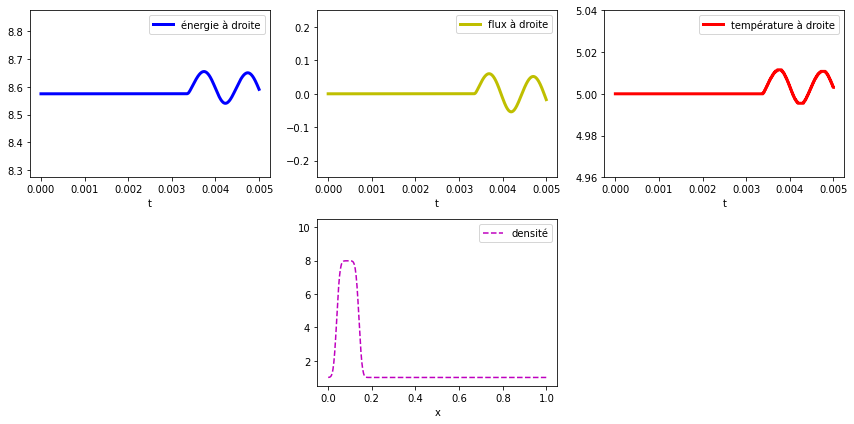

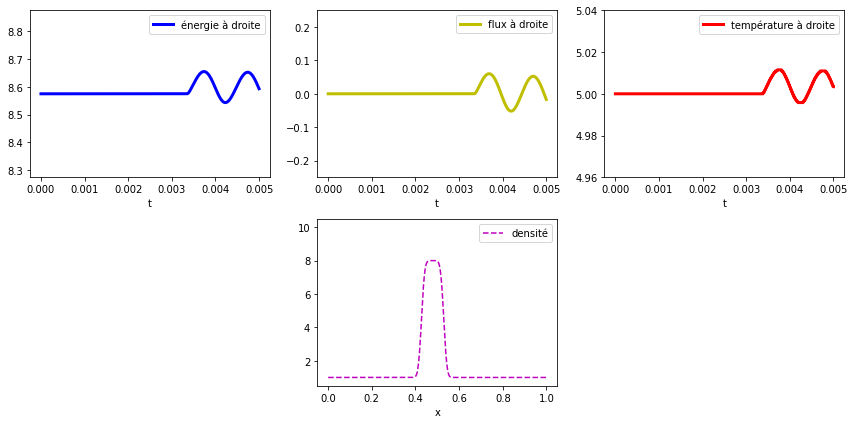

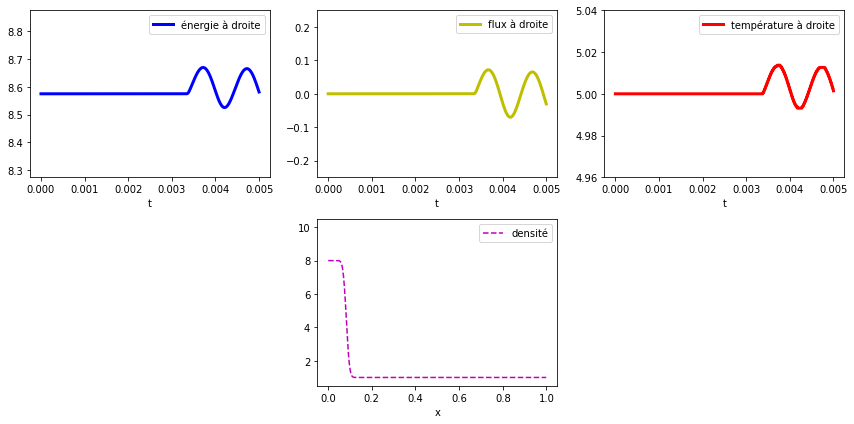

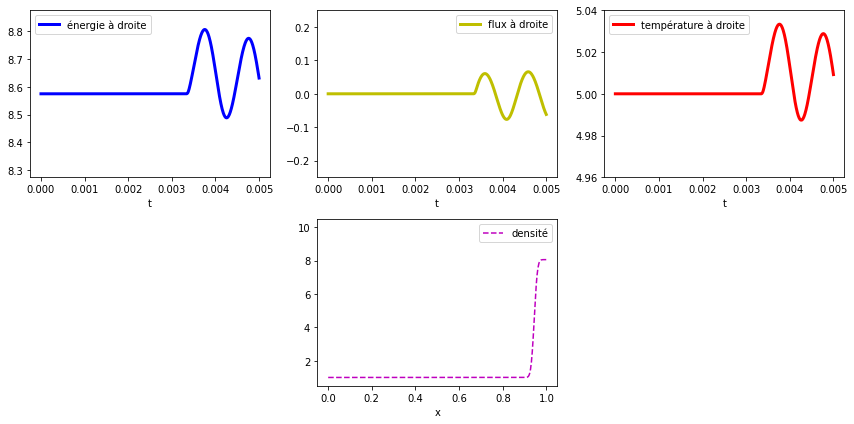

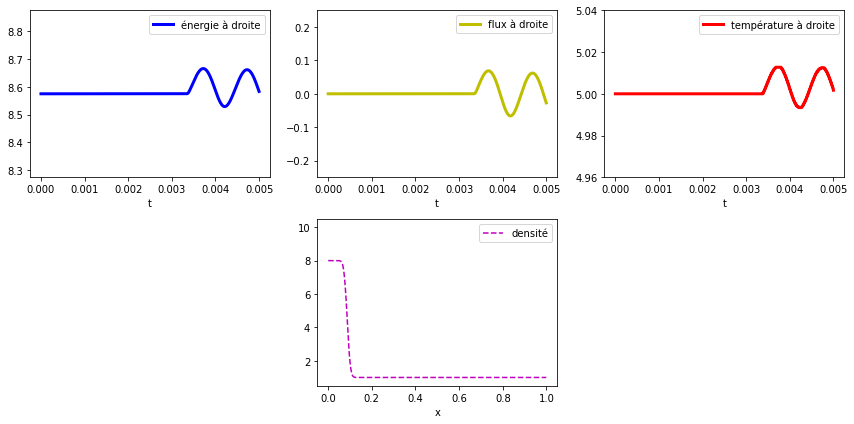

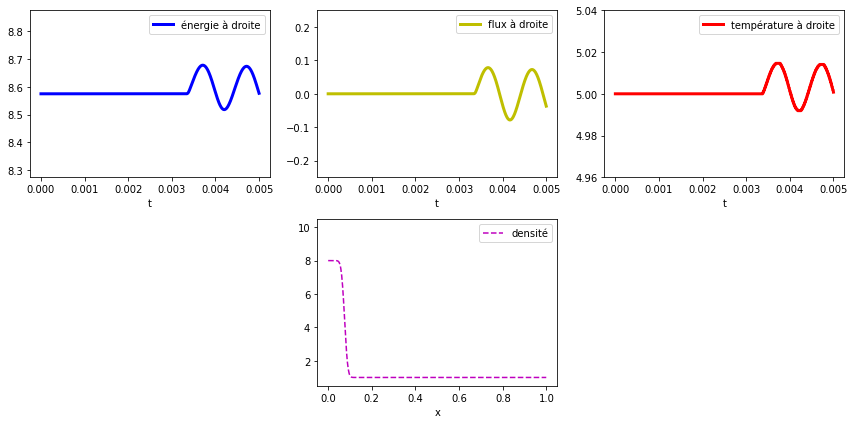

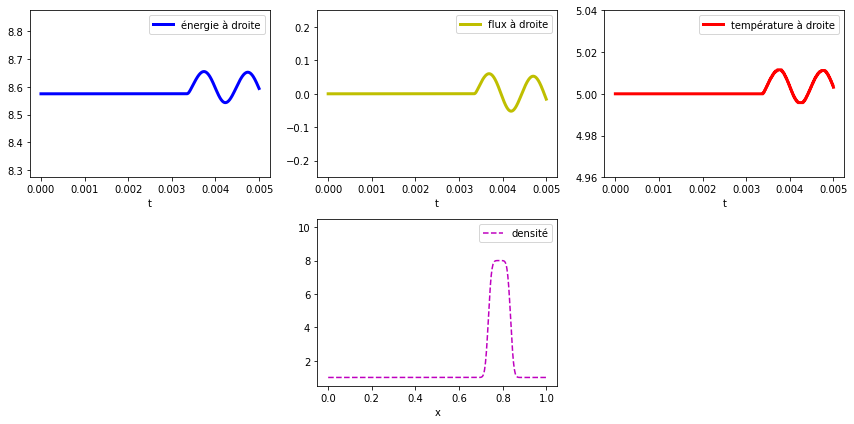

In [ ]:
index = [821, 860, 1823, 2764, 2834, 2937, 2976]

for i in index:
  plot_io(i)

## Creation des inputs X

Pour chacun des signaux E_r, F_r et T_r, il faut tout d'abord:
- Tronquer le signal pour ne ne garder que la fin
- Reechantilloner le signal pour ne garder que 20, voir 50 pas de temps

In [ ]:
""" Permet de couper le debut du signal, parite toujours constante. Retourne la fraction de fin """
def trim(input, ratio):               # verifier que 0 < ratio < 1
    len_input = len(input)
    len_output = int(len_input*ratio)
    return input[len_input-len_output:]

""" Fonction pour extraire n pas d'iterations """
def resample(input, len_output):      # verifier que len_output < len_input
    len_input = len(input)
    output = []
    for i in np.arange(0, len_input, len_input/len_output):
        output.append(input[int(i)])
    return np.array(output)


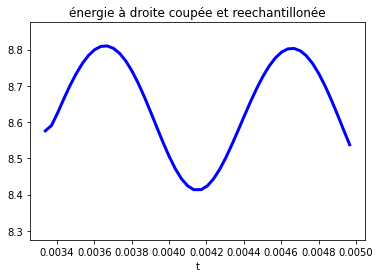

In [ ]:
""" Testons avec un exemple """
t = np.array(df_t.loc[index, 't'])
E_r = np.array(df_t.loc[index, 'E_r'])

ratio, len_X = 1/3, 50
t = resample(trim(t, ratio), len_X)
E_r = resample(trim(E_r, ratio), len_X)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(t, E_r, 'b', lw=3)
ax.set_title('énergie à droite coupée et reechantillonée')
ax.set_ylim(8.275, 8.875)
ax.set_xlabel('t');

In [ ]:
""" Generation les inputs X """

size = len(df_t)
X = np.empty(shape=(size, 3, len_X), dtype=float)

for i in range(size):
    X[i][0] = resample(trim(df_t.loc[i, 'E_r'], ratio), len_X)
    X[i][1] = resample(trim(df_t.loc[i, 'F_r'], ratio), len_X)
    X[i][2] = resample(trim(df_t.loc[i, 'T_r'], ratio), len_X)
    
print("X shape =", X.shape)

X shape = (3101, 3, 50)


In [ ]:
""" Applatissons les donnes avant de continuer """
X = X.reshape([-1,3*len_X])

print("flatten X shape =", X.shape)

flatten X shape = (3101, 150)


## Creations des outputs y

Pour le signal rho, il faut tout d'abord:
- Detecter la position, la hauteur et la larrgeur de chaque crenau

In [ ]:
""" Calcule les decalages a droite et a gauche d'un signal """
def decay(signal):
    signal_right = np.zeros_like(signal)
    signal_right[1:] = signal[:-1]
    signal_right[0] = signal[0]

    signal_left = np.zeros_like(signal)
    signal_left[:-1] = signal[1:]
    signal_left[-1] = signal[-1]
    
    return signal_left, signal_right

In [ ]:
""" Fonction de lissage laplacien 3-means d'un signal """
def smooth(signal):
    signal_left, signal_right = decay(signal)
    return (signal + signal_left + signal_right) / 3.

In [ ]:
""" Pour eliminer les tres tres faibles valeurs dans un signal """
def sharpen(signal, precision):
    return np.where(abs(signal) < precision, np.zeros_like(signal), signal)

In [ ]:
""" Pour afficher un signal et sa derivee seconde """
def plot_signal(ax, signal):
    signal_left, signal_right = decay(signal)
    diff = -2*signal + signal_right + signal_left

    diff = sharpen(diff, 1e-4)
    
    ax[0].plot(signal, 'm--', label='signal')
    ax[1].plot(diff[1:-1], 'c--', label='derivee seconde du signal');
    ax[0].legend()
    ax[1].legend()

In [ ]:
""" Une fonction pour detecter la position, hauteur et largeur des crenaux """
def detect_niches(signal):
    signal_left, signal_right = decay(signal)
    diff = -2*signal + signal_right + signal_left
    
    diff = sharpen(diff, 1e-4)
    
    # zero_crossings = []        # les points de traverse du 0
    niches = []                # les crenaux detectes
    
    prev = diff[0]
    next = diff[2]

    ended = False           # indique si on aretrouve la fin d'un crenau

    start = 1
    end = 1
    
    step = 1               # pas de recherche 
    i = step
    len_signal = len(diff)
    
    while i < len_signal-step:
        prev = diff[i-step]
        val = diff[i]
        next = diff[i+step]
    
        if prev > 0. and next < 0.:
            # zero_crossings.append(i)
            start = i
            ended = False

        if i == len_signal-step-1 and ended == False:
            prev = -1.
            next = 1.

        if prev < 0. and next > 0. and ended==False:
            # zero_crossings.append(i)
            end = i
    
            niche_width = end - start                 # largeur relative a N = len_signal
            niche_center = (end + start) // 2         # position relative a N
            niche_height = signal[niche_center]       # hauteur du crenaux

            niches.append((niche_center, niche_height, niche_width))

            ended = True
        
        # print(i, ended)
        # print(prev, next)

        i += 1
                
    return niches

Position, hauteur et largeur des creneaux detectes
 - (134, 5.0, 69)
 - (257, 2.804259852773157, 14)
 - (349, 9.999999999988198, 49)


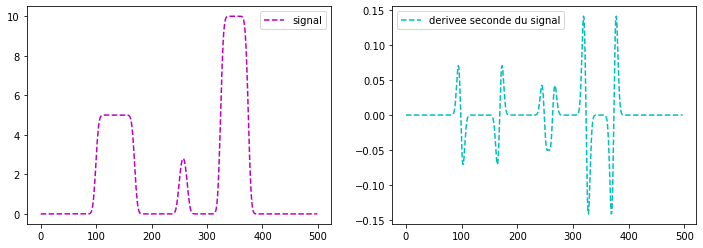

In [ ]:
""" Testons avec un exemple """
signal = np.zeros(500)

signal[100:170] = 5.         # ajout des crenaux
signal[250:265] = 3.
signal[325:375] = 10.

for i in range(25):          # lissage du signal
    signal = smooth(signal)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_signal(ax, signal)

niches = detect_niches(signal)

print("Position, hauteur et largeur des creneaux detectes")
for el in niches:
    print(" -", el)

In [ ]:
""" Testons sur un vrai rho """
# signal = np.array(df_s.loc[4, 'rho'])
# fig, ax = plt.subplots(1, 2, figsize=(12, 4))
# plot_signal(ax, signal)

# niches = detect_niches(signal)
# for el in niches:
#     print(" -", el)

' Testons sur un vrai rho '

In [ ]:
""" Pour creer les y, il faut normaliser par rapport a l'abcisse du domaine """
len_y = 2
y = np.empty(shape=(size, len_y), dtype=float)

for i in range(size):
    x = np.array(df_s.loc[i, 'x'])
    rho = np.array(df_s.loc[i, 'rho'])
    niche = detect_niches(rho)[0]          # on suppose qu'il ny a qu'un seul créneau 
    dx = (x_max - x_min) / df_s.loc[i, 'N']   # xmin = 0, xmax = 1 bien sur. condition necessaire pour cette etude
    
    y[i][0] = x[niche[0]]                     # position relative a x
    y[i][1] = niche[1]                     # hauteur
    # y[i][2] = niche[2]*dx                     # largeur
    
    # print(i, niche)
    # print(i, y[i])

print("y shape =", np.shape(y))

y shape = (3101, 2)


VERDIER QUE CHACUN EST BIEN DETECTE!!!!!!!!!!

In [ ]:
index = []

for i in range(size):
  # if y[i,0] > 0.8 and abs(y[i,1] - 8) < 0.01 :
  if abs(y[i,1] - 8) < 0.01 :
    index.append(i)

print(index)

# print(y[y[:,0] > 0.8])

[821, 860, 1823, 2764, 2834, 2937, 2976]


## Separation des donnees train, test et val

In [ ]:
len_train, len_val = 2500, 400

X_train = X[:len_train]
X_val = X[len_train:len_train+len_val]
X_test = X[len_train+len_val:]

y_train = y[:len_train]
y_val = y[len_train:len_train+len_val]
y_test = y[len_train+len_val:]

print("X shapes =", np.shape(X_train), np.shape(X_val), np.shape(X_test))
print("y shapes =", np.shape(y_train), np.shape(y_val), np.shape(y_test))

X shapes = (2500, 150) (400, 150) (201, 150)
y shapes = (2500, 2) (400, 2) (201, 2)


# APPRENTISSAGE

In [ ]:
""" Le modele s'appelle: Density Reconstruction Neural Network ^^ """ 

model = keras.models.Sequential(name="DRNN")

model.add(keras.layers.Dense(256, activation='relu', input_shape=(3*len_X,)))

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(64, activation='relu'))

model.add(keras.layers.Dropout(0.3))

model.add(keras.layers.Dense(len_y, activation='linear'))

""" Vérifions les parametres du modele """
model.summary()

# print("\nInfos supplémentaires")
# for index in [0, 1, 2]:
#     print("---------------------------")
#     weights, bias = model.layers[index].get_weights()
#     print("layer:", index)
#     print("weights shape:", weights.shape)
#     print("bias shape:", bias.shape)

Model: "DRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               38656     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 55,234
Trainable params: 55,234
Non-trainable params: 0
_________________________________________________________________


Pour la compilation:
- on utlise l'optimiseur Adam
- on utlise la `mse` pour fonction loss
- on observe l'accuracy: la MAE

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.001), 
              loss=keras.losses.mse,
              # metrics=[keras.metrics.AUC()]
              metrics=[keras.metrics.mean_absolute_error]
              )

In [ ]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=100,
                    validation_data=(X_val, y_val))

Train on 2500 samples, validate on 400 samples
Epoch 1/20
2500/2500 [==============================] - 0s 169us/step - loss: 8.0869 - mean_absolute_error: 2.1399 - val_loss: 4.0719 - val_mean_absolute_error: 1.4073
Epoch 2/20
2500/2500 [==============================] - 0s 37us/step - loss: 4.7792 - mean_absolute_error: 1.5773 - val_loss: 3.4239 - val_mean_absolute_error: 1.2622
Epoch 3/20
2500/2500 [==============================] - 0s 41us/step - loss: 4.3534 - mean_absolute_error: 1.4947 - val_loss: 3.2145 - val_mean_absolute_error: 1.1930
Epoch 4/20
2500/2500 [==============================] - 0s 37us/step - loss: 3.8311 - mean_absolute_error: 1.4020 - val_loss: 3.2551 - val_mean_absolute_error: 1.1630
Epoch 5/20
2500/2500 [==============================] - 0s 39us/step - loss: 3.5037 - mean_absolute_error: 1.3334 - val_loss: 2.7267 - val_mean_absolute_error: 1.0756
Epoch 6/20
2500/2500 [==============================] - 0s 37us/step - loss: 3.1077 - mean_absolute_error: 1.2481 - v

Observons la decroissance de la loss

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error']) 



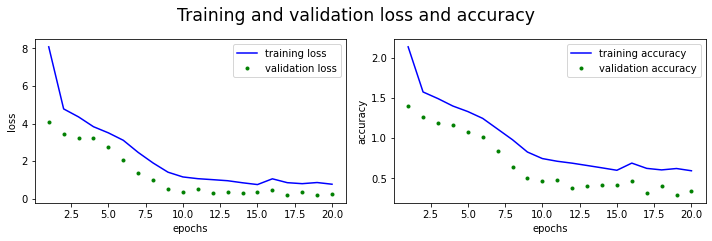

In [ ]:
history_dict = history.history
print(history_dict.keys(), '\n')

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history_dict['mean_absolute_error']
val_acc = history_dict['val_mean_absolute_error']

epochs = range(1, len(loss)+1)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')    
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

Affichons quelque spredictions

In [ ]:
hat_y_test = model.predict(X_test)

In [ ]:
def print_prediction(hat_y_test, nb):
  start = len_train + len_val    #indique le debut des donnes test la dataframe
  for i in range(0, size-start, (size-start)//nb):
    print("index =", i + start)
    print("label:     ", y_test[i])
    print("prediction:", hat_y_test[i], "\n")

print_prediction(hat_y_test, 10)

index = 2900
label:      [0.881 8.969]
prediction: [0.461 7.958] 

index = 2920
label:      [0.341 2.008]
prediction: [0.319 2.048] 

index = 2940
label:      [0.333 3.324]
prediction: [0.357 3.098] 

index = 2960
label:      [0.955 2.238]
prediction: [0.326 2.159] 

index = 2980
label:      [0.069 9.354]
prediction: [0.466 8.148] 

index = 3000
label:      [0.741 3.036]
prediction: [0.343 2.824] 

index = 3020
label:      [0.035 3.331]
prediction: [0.331 2.395] 

index = 3040
label:      [0.905 6.607]
prediction: [0.428 6.455] 

index = 3060
label:      [0.603 7.668]
prediction: [0.445 7.228] 

index = 3080
label:      [0.057 1.273]
prediction: [0.303 1.455] 

index = 3100
label:      [0.541 7.673]
prediction: [0.445 7.232] 



Deffinissons une mesure d'accuracy. On suppose la prediction correcte a l'unite pres pour la hauteur, et au dizieme d'unite pres pour la position.

In [ ]:
""" Calculons l'accuracy """

condition1 = (abs(y_test[:, 0] - hat_y_test[:, 0]) <= .1)
condition2 = (abs(y_test[:, 1] - hat_y_test[:, 1]) <= 1.)

acc_pos = len(hat_y_test[condition1]) / len(hat_y_test)
acc_hg = len(hat_y_test[condition2]) / len(hat_y_test)
acc = len(hat_y_test[condition1 & condition2]) / len(hat_y_test)

print("position accuracy = %.2f"%(acc_pos*100), "%")
print("height accuracy = %.2f"%(acc_hg*100), "%\n")
print("total accuracy = %.2f"%(acc*100), "%")

position accuracy = 23.38 %
height accuracy = 88.56 %

total accuracy = 20.90 %
